In [1]:
#%pip install -U pretty_midi
#%pip install matplotlib
#%pip install seaborn
import pretty_midi
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,accuracy_score, f1_score,classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
data_dir = "Four_composers"

### Extract the relevant features from each MIDI file. Store the features in a list X, and the associated composer in a list y. 

In [3]:
import warnings

def extract_features(midi_file):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning, message="Tempo, Key or Time signature change events found on non-zero tracks")
            midi_data = pretty_midi.PrettyMIDI(midi_file)
    except IOError as e:
        print(f"Error reading file {midi_file}: {str(e)}")
        return None
    except Exception as e:
        print(f"Error parsing MIDI file {midi_file}: {str(e)}")
        return None

    try:
        tempo_changes = midi_data.get_tempo_changes()
        tempo = tempo_changes[1][0] if len(tempo_changes) > 1 and len(tempo_changes[1]) > 0 else 120
    except IndexError:
        tempo = 120

    num_instruments = len(midi_data.instruments)
    
    total_velocity = 0
    total_notes = 0
    for instrument in midi_data.instruments:
        total_velocity += sum(note.velocity for note in instrument.notes)
        total_notes += len(instrument.notes)
    
    avg_velocity = total_velocity / total_notes if total_notes > 0 else 0
    
    pitch_classes = [0] * 12
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitch_classes[note.pitch % 12] += 1
    
    # Ignore key signature errors
    try:
        key = midi_data.key_signature_changes[0].key_number if midi_data.key_signature_changes else 0
    except (ValueError, IndexError):
        key = 0

    return [tempo, num_instruments, avg_velocity, key] + pitch_classes

X = []
y = []
error_count = 0
for composer in os.listdir(data_dir):
    composer_dir = os.path.join(data_dir, composer)
    if os.path.isdir(composer_dir):
        for root, dirs, files in os.walk(composer_dir):
            for midi_file in files:
                if midi_file.endswith('.mid'):
                    file_path = os.path.join(root, midi_file)
                    features = extract_features(file_path)
                    if features is not None:
                        X.append(features)
                        y.append(composer)
                    else:
                        error_count += 1
                        print(f"Skipping file {file_path} due to errors")

if error_count == 0:
    print("No errors found in dataset.")

No errors found in dataset.


### Convert X and y to a Pandas dataframe of selected features

In [4]:
feature_names = ['tempo', 'num_instruments', 'avg_velocity', 'key'] + [f'pitch_class_{i}' for i in range(12)]
df = pd.DataFrame(X, columns=feature_names)
df['composer'] = y

### Visualize tempo distribution of the compositions.

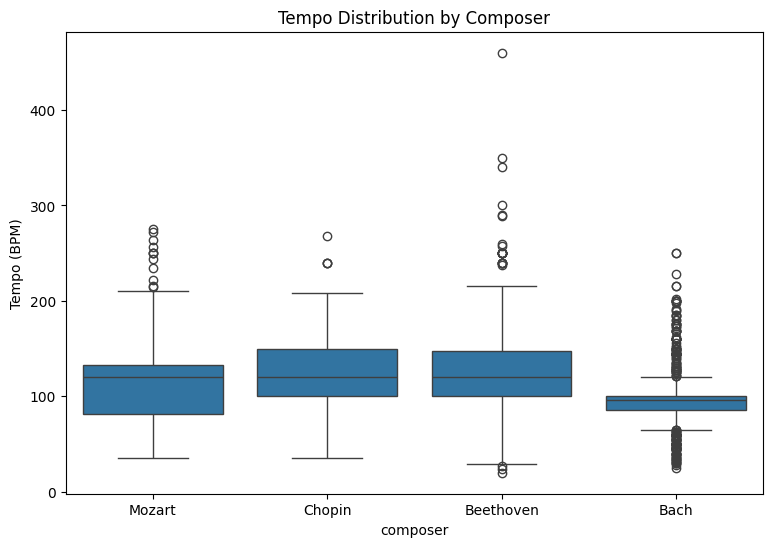

In [5]:
# Create a box plot
plt.figure(figsize=(9, 6))
sns.boxplot(x='composer', y='tempo', data=df)
plt.title('Tempo Distribution by Composer')
plt.ylabel('Tempo (BPM)')
plt.show()

### Visualize the average velocity distribution of the compositions.

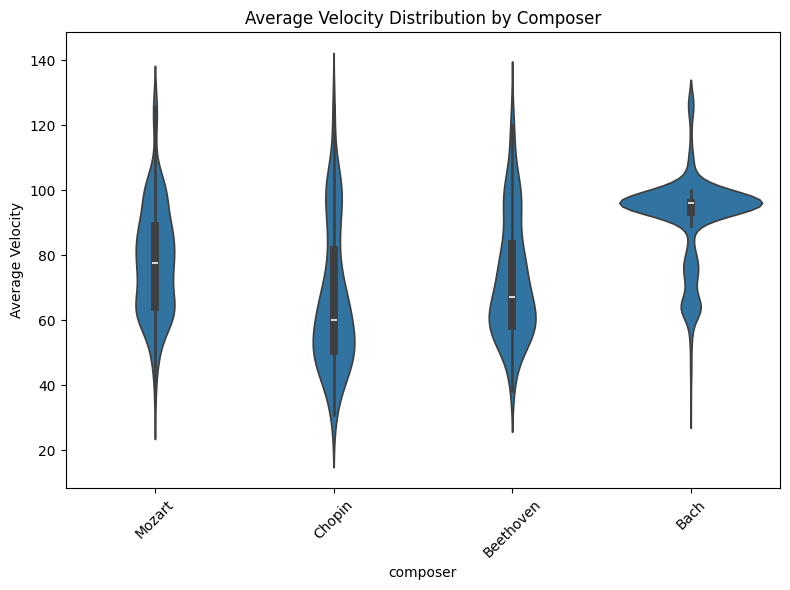

In [6]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='composer', y='avg_velocity', data=df)
plt.title('Average Velocity Distribution by Composer')
plt.ylabel('Average Velocity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualize the number of instruments vs average velocity, by composer

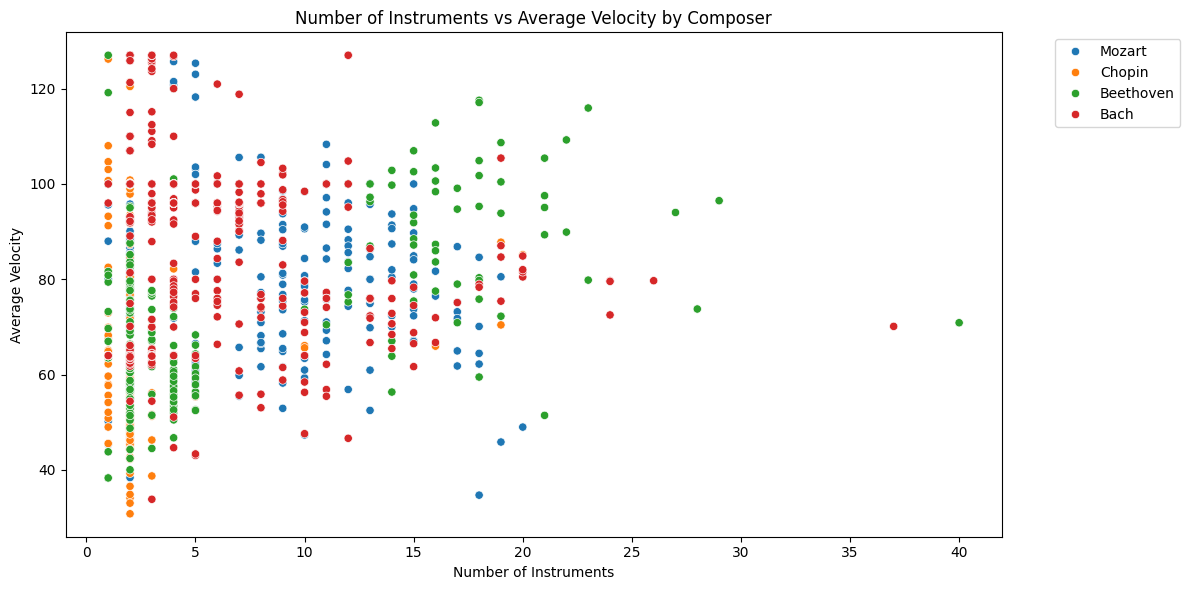

In [7]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='num_instruments', y='avg_velocity', hue='composer', data=df)
plt.title('Number of Instruments vs Average Velocity by Composer')
plt.xlabel('Number of Instruments')
plt.ylabel('Average Velocity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Visualize the normalized pitch class (note) by composer

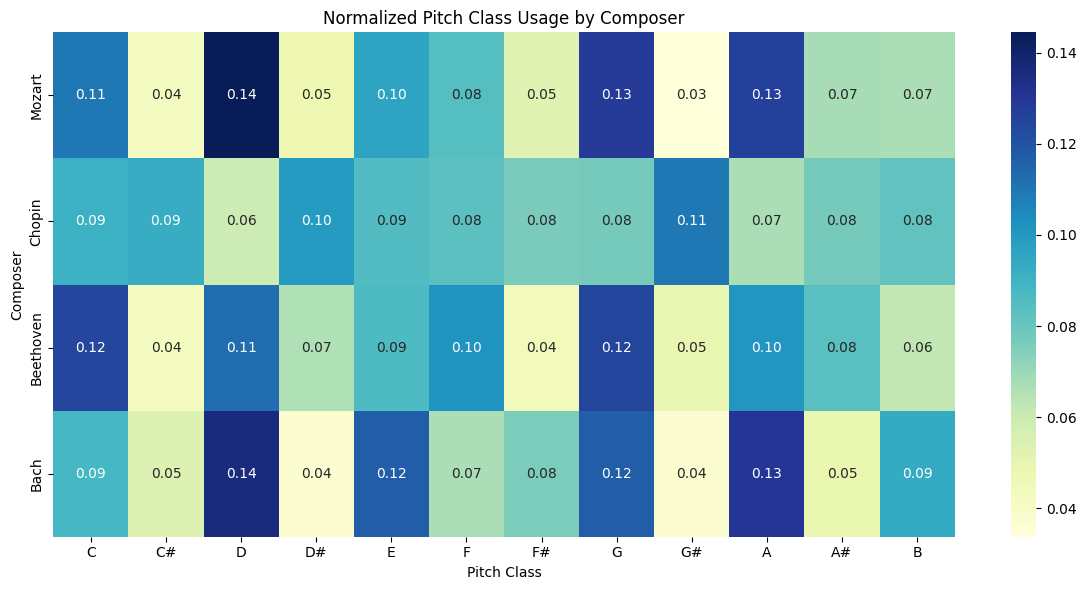

In [15]:
composition_counts = df['composer'].value_counts()   # Count the number of compositions per composer

normalized_df = pd.DataFrame()           # Create a new DataFrame for normalized pitch class usage

# Iterate through each composer
for composer in df['composer'].unique():
    composer_data = df[df['composer'] == composer]   # Let composer_data be data for the current composer
    pitch_class_sums = composer_data[[f'pitch_class_{i}' for i in range(12)]].sum()      # Sum the pitch class values for this composer
    total_sum = pitch_class_sums.sum()                          # Sum the pitch classes
    normalized_pitch_classes = pitch_class_sums / total_sum     # Normalize by dividing by the total sum of all pitch classes
    normalized_df[composer] = normalized_pitch_classes

normalized_df = normalized_df.T                      # Transpose the DataFrame so composers are rows and pitch classes are columns

pitch_class_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
normalized_df.columns = pitch_class_names            # Rename columns to pitch class names

plt.figure(figsize=(12, 6))
sns.heatmap(normalized_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Normalized Pitch Class Usage by Composer')
plt.xlabel('Pitch Class')
plt.ylabel('Composer')
plt.tight_layout()
plt.show()

### Pair-plot to visualize the four selected features.

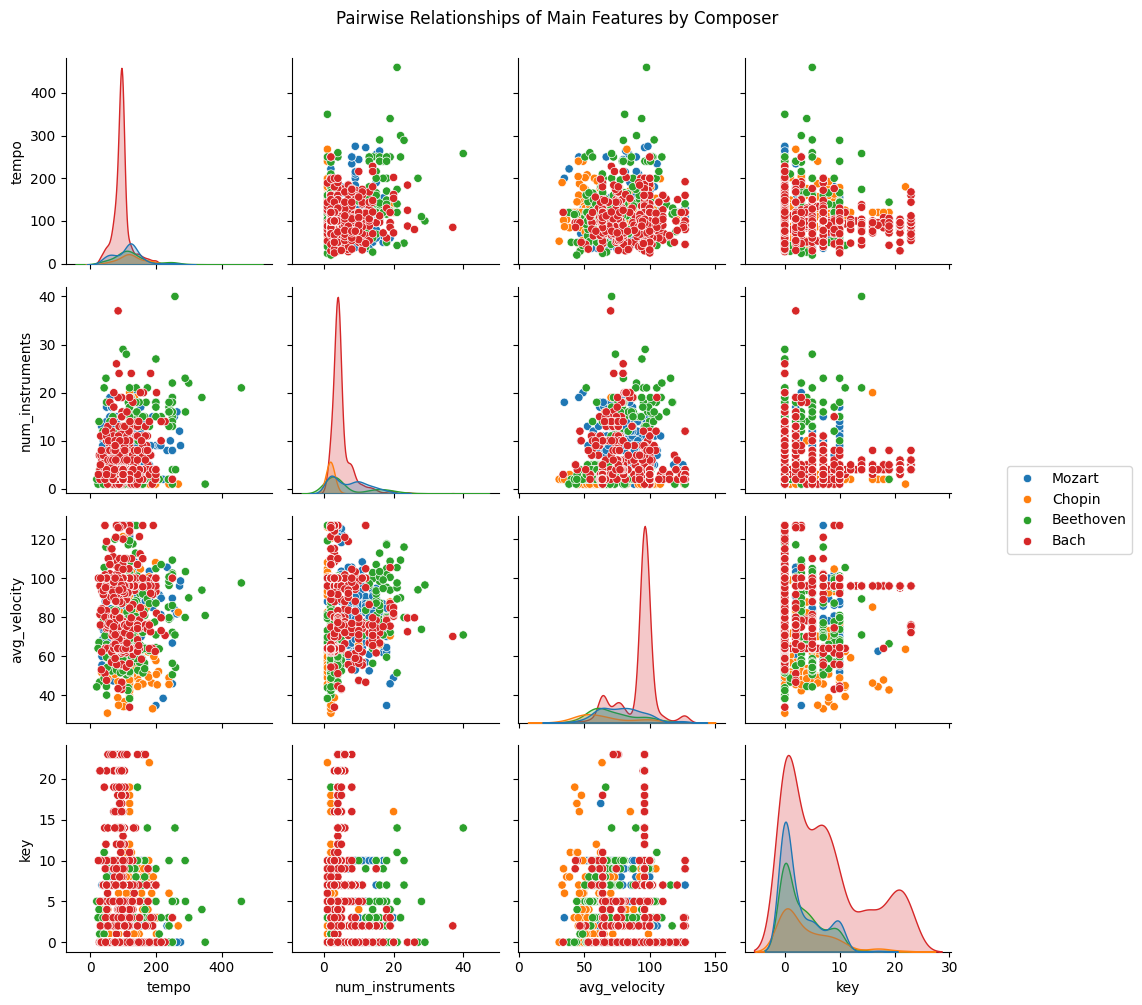

In [9]:
# Pairplot for main features
main_features = ['tempo', 'num_instruments', 'avg_velocity', 'key']
g = sns.pairplot(df[main_features + ['composer']], hue='composer', vars=main_features)
g._legend.remove()     # Remove the original legend

handles = g._legend.legend_handles
labels = g._legend.get_texts()
unique_labels = list(dict.fromkeys([t.get_text() for t in labels]))  # Remove duplicates while preserving order
unique_handles = [handles[next(i for i, t in enumerate(labels) if t.get_text() == label)] for label in unique_labels]

g.fig.legend(unique_handles, unique_labels, bbox_to_anchor=(0.9, 0.5), loc='center left', borderaxespad=0)
plt.suptitle('Pairwise Relationships of Main Features by Composer', y=1)
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust the right margin to make room for the legend
plt.show()

### Radar plot of pitch class usage

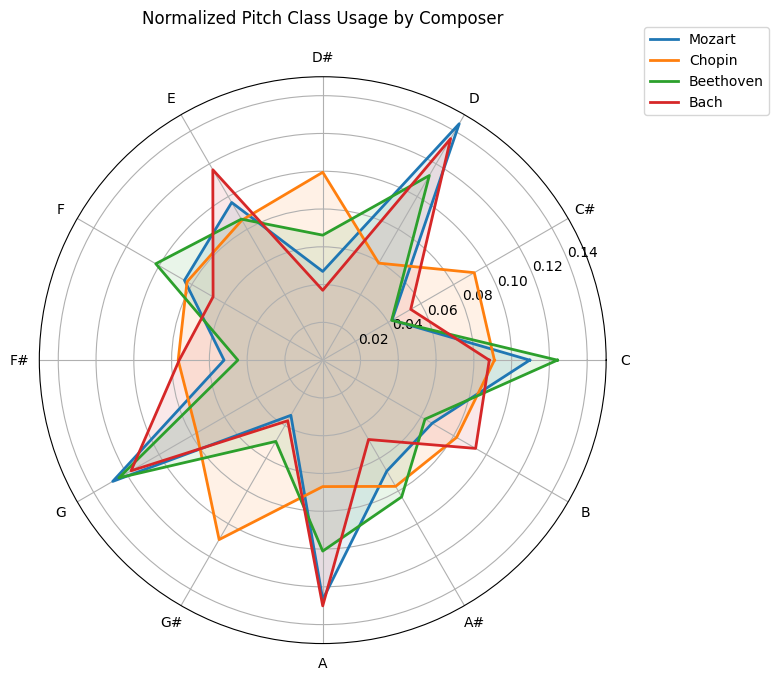

In [17]:

# Set up the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

# Number of variables
num_vars = len(pitch_class_names)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the plot by appending the first value to the end
angles += angles[:1]

# Plot data for each composer
for composer in normalized_df.index:
    values = normalized_df.loc[composer].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=composer)
    ax.fill(angles, values, alpha=0.1)

# Set the labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(pitch_class_names)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Add title
plt.title('Normalized Pitch Class Usage by Composer', y=1.08)

# Show the plot
plt.tight_layout()
plt.show()

### Visualize the degree of musical chromaticism by plotting the proportion of non-diatonic notes used in each key signature.

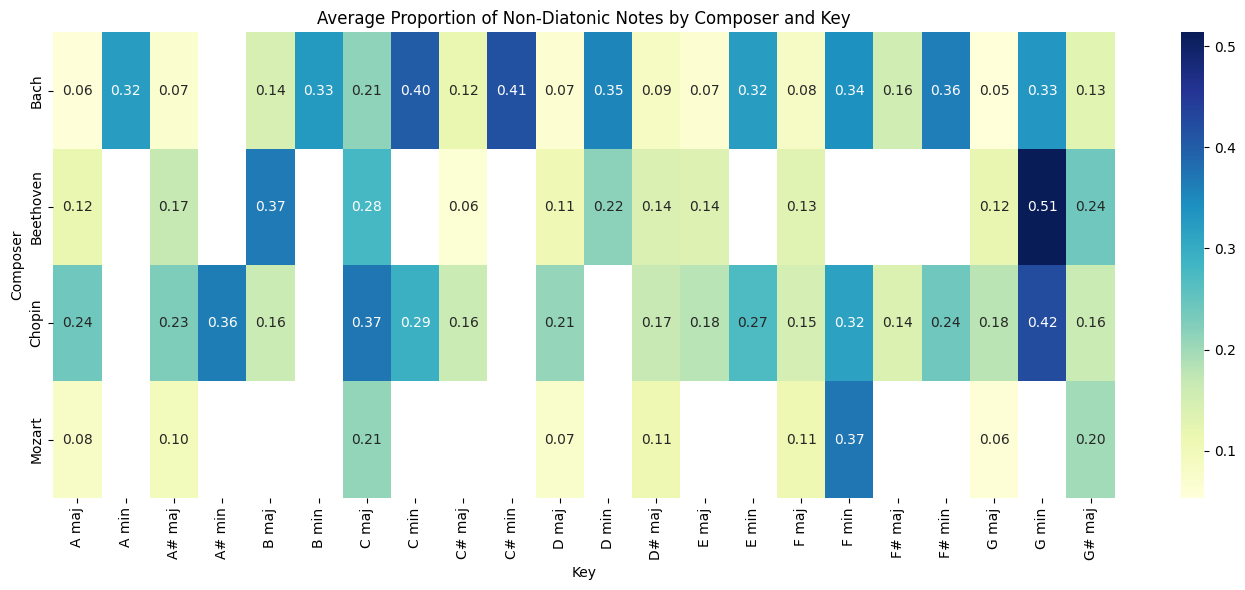

In [11]:
# Convert key numbers to key names
def calculate_non_diatonic_proportion(row):
    pitch_classes = [row[f'pitch_class_{i}'] for i in range(12)]
    key = row['key']
    major_scales = [
        [0, 2, 4, 5, 7, 9, 11],  # C Major
        [1, 3, 5, 6, 8, 10, 0],  # C# Major
        [2, 4, 6, 7, 9, 11, 1],  # D Major
        [3, 5, 7, 8, 10, 0, 2],  # D# Major
        [4, 6, 8, 9, 11, 1, 3],  # E Major
        [5, 7, 9, 10, 0, 2, 4],  # F Major
        [6, 8, 10, 11, 1, 3, 5], # F# Major
        [7, 9, 11, 0, 2, 4, 6],  # G Major
        [8, 10, 0, 1, 3, 5, 7],  # G# Major
        [9, 11, 1, 2, 4, 6, 8],  # A Major
        [10, 0, 2, 3, 5, 7, 9],  # A# Major
        [11, 1, 3, 4, 6, 8, 10]  # B Major
    ]
    diatonic_scale = major_scales[key % 12]
    total_notes = sum(pitch_classes)
    non_diatonic_notes = sum(pitch_classes[i] for i in range(12) if i not in diatonic_scale)   
    return non_diatonic_notes / total_notes if total_notes > 0 else 0

# For each row, what proportion of notes are non-diatonic
df['non_diatonic_prop'] = df.apply(calculate_non_diatonic_proportion, axis=1)
    
def key_to_name(key):
    key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    mode = 'min' if key >= 12 else 'maj'
    return f'{key_names[key % 12]} {mode}'

# Add a new column of df with the key names
df['key_name'] = df['key'].apply(key_to_name)

# Create the pivot table using key names
pivot_df = df.pivot_table(values='non_diatonic_prop', index='composer', columns='key_name', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Average Proportion of Non-Diatonic Notes by Composer and Key')
plt.xlabel('Key')
plt.ylabel('Composer')
plt.tight_layout()
plt.show()

Bach was musically adventurous, and composed in every key. Chopin also was not afraid to use minor key signatures and use non-diatonic notes. Mozart preferred major key signatures and infrequently used non-diatonic notes. Beethoven was somewhere in between, being mostly diatonic, but sometimes very much not so.

### Convert X and y into arrays. Perform train-test split.

In [12]:
X_np = np.array(X)
y_np = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2)

### Print raw values of X_train and X_test to visualize range

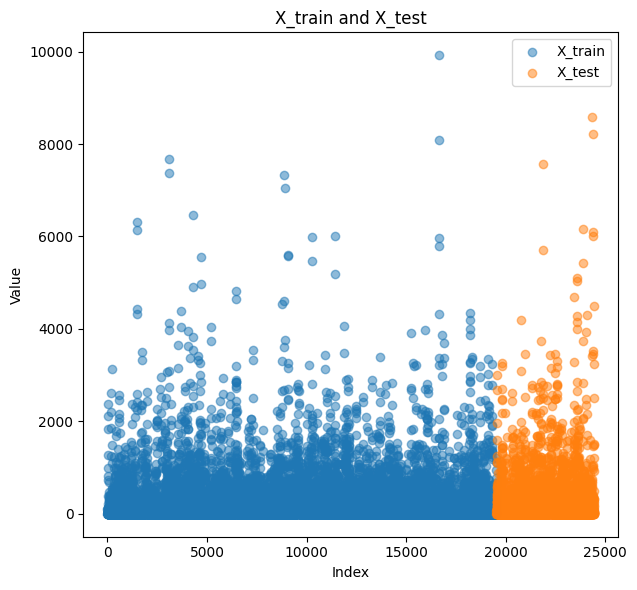

In [13]:
plt.figure(figsize=(12, 6))

def flatten_if_needed(data):
    if len(data.shape) > 1 and data.shape[1] > 1:
        return data.flatten()
    return data

# Plot X_train and X_test
plt.subplot(1, 2, 1)
X_train_flat = flatten_if_needed(X_train)
X_test_flat = flatten_if_needed(X_test)

plt.scatter(range(len(X_train_flat)), X_train_flat, alpha=0.5, label='X_train')
plt.scatter(range(len(X_train_flat), len(X_train_flat) + len(X_test_flat)), X_test_flat, alpha=0.5, label='X_test')
plt.title('X_train and X_test')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

### Large range in dataset values suggests the need for Standard Scaling on X_train and X_test to normalize the data. 

In [14]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(1221, 16)
(306, 16)


### SMOTE resampling on the training sets

In [16]:
#%pip install -U -q imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

### Visualize the data imbalance, and correction after SMOTE.

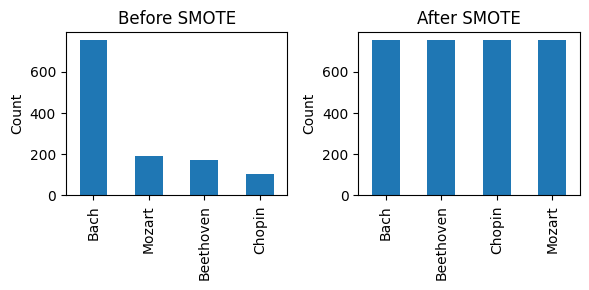

In [17]:
# Convert y_train and y_train_smote to pandas Series
y_train_series = pd.Series(y_train)
y_train_smote_series = pd.Series(y_train_smote)

f = plt.figure(figsize=(6, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Plot before SMOTE
ax1 = f.add_subplot(1, 2, 1)
y_train_series.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("Before SMOTE")
ax1.set_ylabel("Count")

# Plot after SMOTE
ax2 = f.add_subplot(1, 2, 2)
y_train_smote_series.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("After SMOTE")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

### SVM

In [18]:
# Train a Support Vector Machine classifier
svm_clf = SVC(kernel='rbf', gamma=0.4, degree=5, C=18.0, decision_function_shape='ovr')
svm_clf.fit(X_train_scaled_smote, y_train_smote)

SVC(C=18.0, degree=5, gamma=0.4)

### Train model using radial basis vector kernel.

In [19]:
y_pred = svm_clf.predict(X_test_scaled)
rbf_accuracy = accuracy_score(y_test, y_pred)
rbf_f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  74.51
F1 (RBF Kernel):  75.27


In [20]:
# Generate and print the classification report
report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Bach       0.90      0.83      0.86       171
   Beethoven       0.45      0.80      0.58        41
      Chopin       0.74      0.57      0.64        30
      Mozart       0.69      0.56      0.62        64

    accuracy                           0.75       306
   macro avg       0.70      0.69      0.68       306
weighted avg       0.78      0.75      0.75       306



### Print confusion matrix.

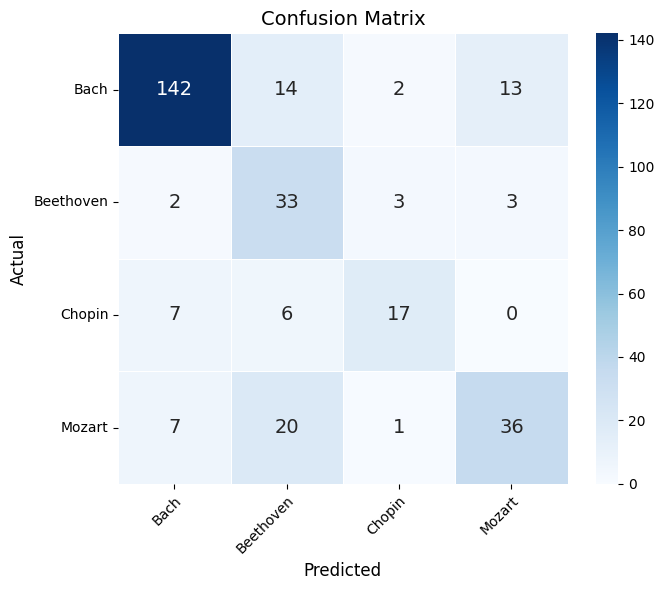

In [21]:
labels = sorted(set(y_test) | set(y_pred))

cmatrix = confusion_matrix(y_test, y_pred, labels=labels)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability
cmap = plt.colormaps.get_cmap("Blues")
fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(cmatrix, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14},
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()

### LSTM

#### Reshape X train and X test

In [22]:
num_classes = len(np.unique(y_train_smote))
X_train_reshaped = X_train_scaled_smote.reshape((X_train_scaled_smote.shape[0], X_train_scaled_smote.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

input_shape = (X_train_scaled_smote.shape[1], 1)

In [23]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_smote)
y_test_encoded  = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

In [24]:
def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    for i in range(data.shape[0] - sequence_length + 1):
        seq = data[i:i+sequence_length]
        label = labels[i+sequence_length-1]  # Use the label of the last timestep in the sequence
        sequences.append(seq)
        sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

sequence_length = 5  # You can adjust this
X_train_seq, y_train_seq = create_sequences(X_train_reshaped, y_train_categorical, sequence_length)

X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_test_seq, y_test_seq  = create_sequences(X_test_reshaped, y_test_categorical, sequence_length)

#### Build and train model

In [25]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from tensorflow.keras.callbacks import Callback

lstm_model = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),
    BatchNormalization(),
    LSTM(15, return_sequences=True,recurrent_dropout=0.7),
    BatchNormalization(),
    Dropout(0.6),
    
    BatchNormalization(),
    LSTM(5, return_sequences=False,recurrent_dropout=0.7),
    BatchNormalization(),
    Dropout(0.6),

#    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03)),
#    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.03)),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=30, min_lr=1e-4, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

# Print statistics every 5 epochs to decrease training clutter
class EpochPrintCallback(Callback):
    def __init__(self, print_every=5):
        super(EpochPrintCallback, self).__init__()
        self.print_every = print_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every == 0:
            print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
            print(f"loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
epoch_print = EpochPrintCallback(print_every=10)

# Train the model
result = lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_test_seq, y_test_seq), epochs=1000,  # Set a higher number, early stopping will prevent overfitting
    batch_size=32, callbacks=[lr_scheduler, early_stopping, epoch_print], verbose=0)


Epoch 10/1000
loss: 0.8328 - accuracy: 0.6288 - val_loss: 1.0029 - val_accuracy: 0.5662

Epoch 20/1000
loss: 0.8153 - accuracy: 0.6577 - val_loss: 0.9878 - val_accuracy: 0.5993

Epoch 30/1000
loss: 0.7596 - accuracy: 0.6614 - val_loss: 0.9536 - val_accuracy: 0.6060

Epoch 40/1000
loss: 0.7640 - accuracy: 0.6650 - val_loss: 0.9619 - val_accuracy: 0.5894

Epoch 50/1000
loss: 0.7448 - accuracy: 0.6750 - val_loss: 0.9188 - val_accuracy: 0.6126

Epoch 60/1000
loss: 0.7522 - accuracy: 0.6707 - val_loss: 0.8597 - val_accuracy: 0.6159

Epoch 70/1000
loss: 0.6947 - accuracy: 0.6939 - val_loss: 0.8698 - val_accuracy: 0.6060

Epoch 80/1000
loss: 0.7257 - accuracy: 0.6740 - val_loss: 0.8740 - val_accuracy: 0.6258

Epoch 90/1000
loss: 0.7305 - accuracy: 0.6806 - val_loss: 0.8570 - val_accuracy: 0.6391

Epoch 100/1000
loss: 0.7274 - accuracy: 0.6796 - val_loss: 0.9009 - val_accuracy: 0.6225

Epoch 110/1000
loss: 0.7112 - accuracy: 0.6667 - val_loss: 0.9119 - val_accuracy: 0.6291

Epoch 120/1000
los

#### Evaluate training

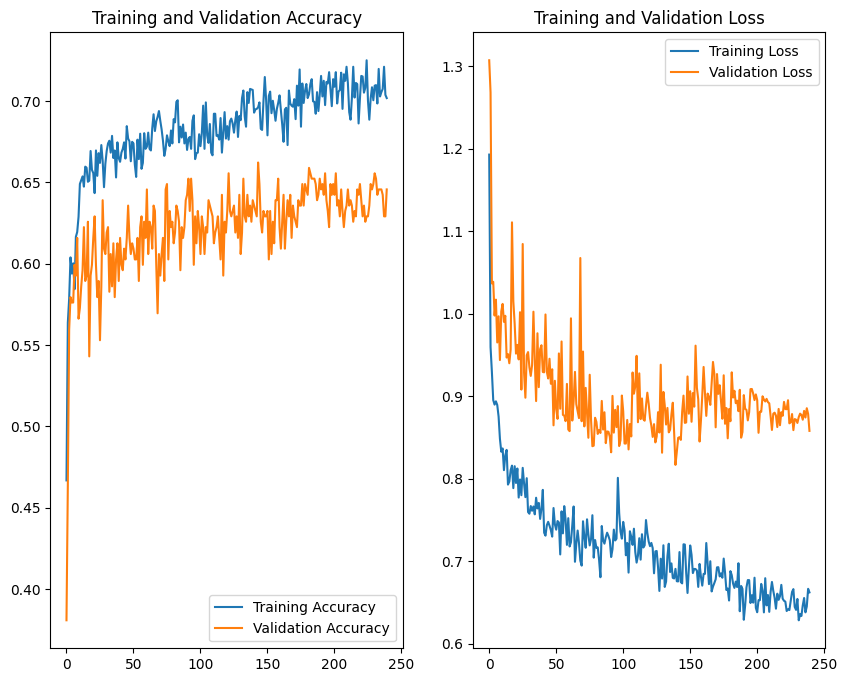

In [26]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Make predictions

In [27]:
lstm_model.training=False
y_pred = lstm_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_seq, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [28]:
# Convert y_test_categorical back to class labels
y_test_classes = np.argmax(y_test_seq, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, zero_division=1)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       169
           1       0.33      0.30      0.32        40
           2       0.63      0.40      0.49        30
           3       0.50      0.46      0.48        63

    accuracy                           0.64       302
   macro avg       0.55      0.50      0.52       302
weighted avg       0.63      0.64      0.63       302



### Print Confusion matrix

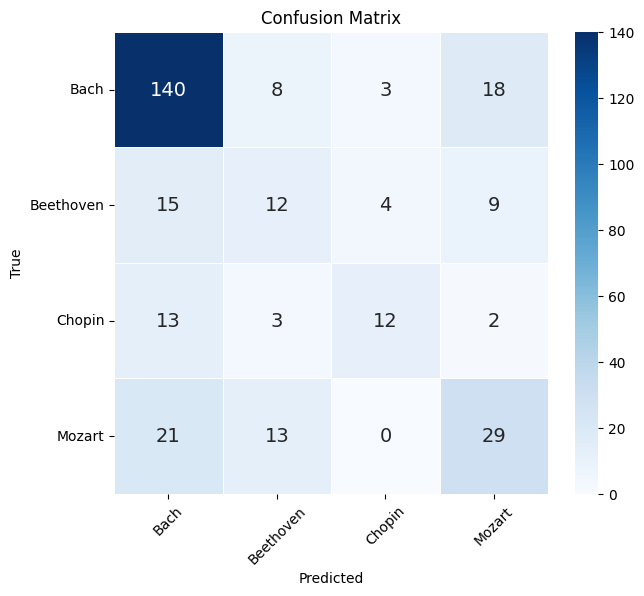

<Figure size 1000x800 with 0 Axes>

In [29]:
# Compute confusion matrix
cmatrix_lstm = confusion_matrix(y_true, y_pred_classes)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability

class_names = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
fig, ax = plt.subplots(figsize=figsize)
plt.figure(figsize=(10, 8))
cmap = plt.colormaps.get_cmap("Blues")

# Create the confusion matrix heatmap
sns.heatmap(cmatrix_lstm, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14})

# Set labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(len(class_names)) + 0.5)
ax.set_yticks(np.arange(len(class_names)) + 0.5)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
plt.show()

### CNN

#### Build model and train

In [36]:
cnn_model = Sequential([
    # Input normalization
    Input(shape=input_shape),
    BatchNormalization(),
    
    # First convolutional block
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    # Second convolutional block
    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Third convolutional block
    Conv1D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.4),
    
    # Dense layers
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
result = cnn_model.fit(X_train_reshaped, y_train_categorical, validation_split=0.1, epochs=100,  # Set a higher number, early stopping will prevent overfitting
    batch_size=32, callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3681 - loss: 1.7677 - val_accuracy: 0.1026 - val_loss: 1.8899 - learning_rate: 0.0010
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5614 - loss: 1.2147 - val_accuracy: 0.0166 - val_loss: 2.0185 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6063 - loss: 1.0791 - val_accuracy: 0.0430 - val_loss: 1.7994 - learning_rate: 0.0010
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6166 - loss: 1.0136 - val_accuracy: 0.4834 - val_loss: 1.1260 - learning_rate: 0.0010
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6357 - loss: 0.9407 - val_accuracy: 0.4536 - val_loss: 1.1099 - learning_rate: 0.0010
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6828 - loss: 0.8326 - val_accuracy: 0.4801 - val_loss: 1.1121 - learning_rate: 0.0010
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6880 - loss: 0.8045 - val_

#### Evaluate training

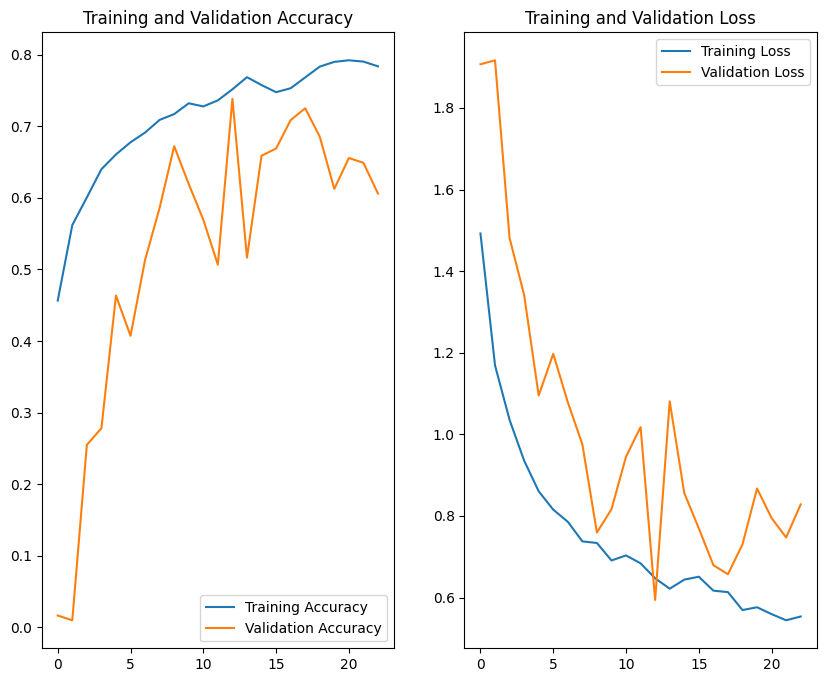

In [31]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Make predictions

In [32]:
y_pred = cnn_model.predict(X_test_reshaped)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [33]:
# Convert y_pred from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical back to class labels
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, zero_division=1)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.95      0.65      0.77       171
           1       0.41      0.51      0.46        41
           2       0.43      0.73      0.54        30
           3       0.51      0.69      0.58        64

    accuracy                           0.65       306
   macro avg       0.57      0.65      0.59       306
weighted avg       0.73      0.65      0.67       306



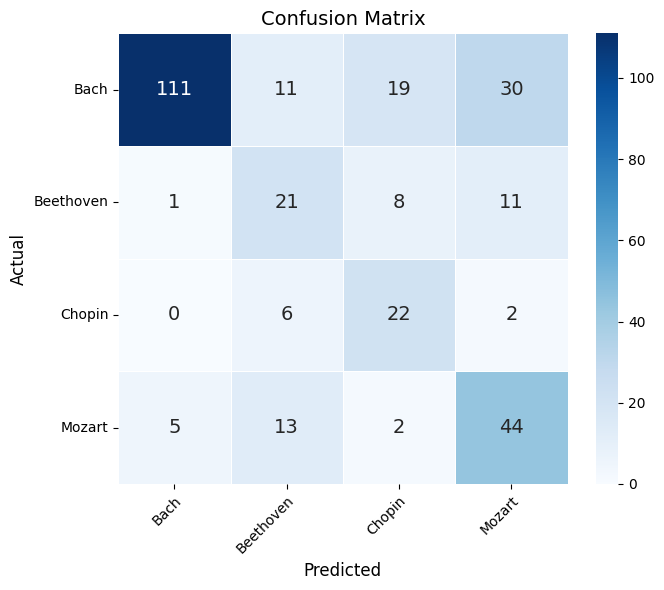

In [34]:
cmatrix_cnn = confusion_matrix(y_test_classes, y_pred_classes)
fontsize = 7
figsize = (7, 6)
cmap = plt.colormaps.get_cmap("Blues")
fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(cmatrix_cnn, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14},
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()